In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sc.constants as cs
from sc import payoff as po
from yq.scripts import simulation as yqsm

print(pd.__version__)

2.1.2


In [3]:
paths_arr = yqsm.read_sim_data('gbm/archive', '20231111_195045_022812', pd.Timestamp('2023-08-14'), pd.Timestamp('2023-08-15'))
print(paths_arr)

[[               LONN.SW     SIKA.SW
Date                              
2023-08-15  490.333487  264.703009
2023-08-16  487.195147  267.376224
2023-08-17  496.219571  271.813779
2023-08-18  504.632152  273.777250
2023-08-21  510.762854  272.677031
...                ...         ...
2024-07-24  508.725460  185.112811
2024-07-25  516.176565  191.501652
2024-07-26  520.366633  192.632441
2024-07-29  496.490567  187.765095
2024-07-30  496.068044  187.204987

[241 rows x 2 columns],                LONN.SW     SIKA.SW
Date                              
2023-08-15  504.813299  269.670459
2023-08-16  499.683298  267.610921
2023-08-17  514.237971  275.584777
2023-08-18  516.119661  279.238980
2023-08-21  510.364465  277.514212
...                ...         ...
2024-07-24  777.400497  273.848537
2024-07-25  776.854265  280.920715
2024-07-26  803.856863  280.754224
2024-07-29  800.282368  280.636200
2024-07-30  793.406435  280.253607

[241 rows x 2 columns],                LONN.SW     SIKA.SW
Dat

In [4]:
#prep for multipath

df_sim_array_14 = []
for df in paths_arr[0]:
    df_sim_array_14.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))

df_sim_array_15 = []
for df in paths_arr[1]:
    df_sim_array_15.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))

In [12]:
prices_14 = po.pricing_multiple(df_sim_array_14)
print(sum(prices_14) / len(prices_14))

prices_15 = po.pricing_multiple(df_sim_array_15)
print(prices_15)
print(sum(prices_15) / len(prices_15))

933.9164664251789
[1016.1756665362284, 1046.297949756095, 279.7641024131444, 263.80901776801795, 1031.613114765797, 1060.816949397637, 1046.297949756095, 1016.1756665362284, 239.13079168785544, 1046.297949756095, 1016.1756665362284, 204.30766637295935, 1031.613114765797, 1060.816949397637, 370.21367896859147, 1060.816949397637, 1046.297949756095, 219.3451056643809, 256.5945109729719, 1060.816949397637, 1031.613114765797, 1046.297949756095, 1060.816949397637, 1016.1756665362284, 1060.816949397637, 1046.297949756095, 1016.1756665362284, 1016.1756665362284, 385.1145535804387, 1046.297949756095, 1016.1756665362284, 1016.1756665362284, 204.1891687963862, 1060.816949397637, 1060.816949397637, 186.35595487806023, 1031.613114765797, 1016.1756665362284, 1046.297949756095, 335.8522018892245, 1016.1756665362284, 1031.613114765797, 1046.297949756095, 329.3468134306048, 1060.816949397637, 1060.816949397637, 1060.816949397637, 1060.816949397637, 1060.816949397637, 1016.1756665362284, 403.27770849410

In [ ]:
# from pathlib import Path
# from yq.utils import path as yq_path
# import os
# paths_arr = yqsm.read_sim_data('gbm', '20231111_195045_022812', pd.Timestamp('2023-08-09'), pd.Timestamp('2023-08-15'))
# df_sim = paths_arr[0][0]

# fig, ax = plt.subplots(figsize=(10,6))

# hist_data = po.get_historical_assets_all()
# hist_df = hist_data[(hist_data.index >= cs.INITIAL_FIXING_DATE) 
#                            & (hist_data.index <= cs.FINAL_FIXING_DATE)]
# for asset in cs.ASSET_NAMES:
#     ax.plot(hist_df.index, hist_df[asset], alpha=0.5, label=asset)
# for col in df_sim.columns:
#     ax.plot(df_sim.index, df_sim[col], alpha=0.5, label=col)


# title_str = f"PPD: "
# plt.title(title_str)
# plt.legend(loc='upper right')
# plt.tight_layout()
# stor_dir = yq_path.get_plots_path(Path(os.getcwd()).parent)                     
# stor_dir.mkdir(parents=True, exist_ok=True)
# file_path = stor_dir.joinpath(f'test.png')
# plt.savefig(file_path, bbox_inches='tight')

       Payout       Date
0   20.000000 2023-11-06
0   20.000000 2024-02-05
0   20.000000 2024-05-06
0   20.000000 2024-08-05
0  204.375458 2024-08-05


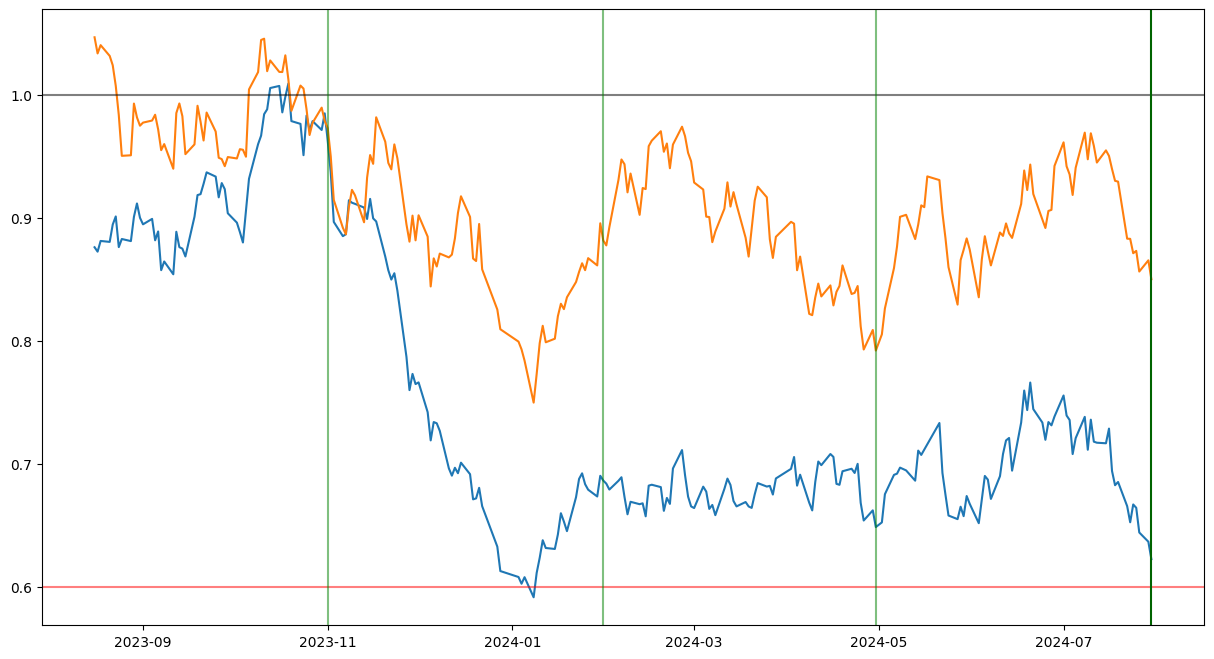

In [14]:
df_plot = df_sim_array_15[2].copy(deep = True)
print(po.payouts(df_plot, barrierHit = False))
for asset in cs.ASSET_NAMES:
    df_plot[asset] = df_plot[asset] / cs.INITIAL_LEVELS[asset]
plt.figure(figsize = (15, 8))
plt.plot(df_plot)
plt.axhline(y=1, c = "black", alpha = 0.5)
plt.axhline(y = 0.6, c = "red", alpha = 0.5)
plt.axvline(x = cs.FINAL_FIXING_DATE, c = "darkgreen")
for date in cs.EARLY_REDEMPTION_OBSERVATION_DATES:
    plt.axvline(x = date, c = "green", alpha = 0.5)



In [19]:
#Entire process

first_date = pd.Timestamp('2023-08-09')
last_date = pd.Timestamp('2023-11-09')

#load simulated paths from csvs
total_data = yqsm.read_sim_data('gbm/archive', '20231111_195045_022812', first_date, last_date)

est_price = []
for single_day in total_data:
    #rename columns
    df_sim_array = []
    for df in single_day:
        df_sim_array.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))
    
    prices = po.pricing_multiple(df_sim_array)
    est_price.append(sum(prices) / len(prices))
print(est_price)




[836.2382322009278, 921.4126998490907, 823.8121306137967, 933.9164664251789, 864.6596844327998, 853.9741418066558, 844.7219187111513, 884.006525022842, 788.0840410809938, 830.029261395828, 874.0848174203389, 854.6611680674793, 871.9667008590536, 875.6954008650137, 929.0212893432915, 907.4988492969087, 949.5859792127746, 876.8836479914784, 887.6082203074044, 904.2924482178638, 927.8915809272274, 914.2480581254256, 924.5374514501989, 955.6853827375085, 917.4124769773819, 885.0230651189315, 894.6269388460604, 939.4544848749658, 720.502524815629, 793.3693858532799, 806.3180845428624, 767.3294276971169, 768.8460610100695, 802.4720345702706, 824.7974764369106, 751.1873103631676, 800.8362215924386, 722.8912796564645, 721.1547995383523, 731.1493858335136, 722.3230285092653, 696.1594600367164, 782.6057088654837, 764.6526057465792, 742.2682222927161, 731.3881654814701, 728.1721488135695, 808.5285488186101, 747.8168166626455, 500.9369596770737, 428.1678808789212, 367.52117545853866, 320.224167307

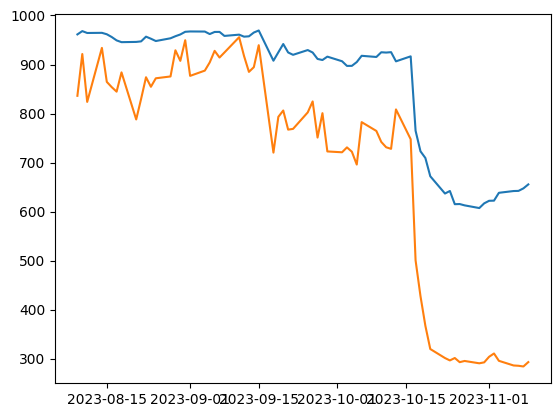

In [26]:
df_product = po.get_product_price(pd.Timestamp('2023-11-09'))
df_product = df_product.loc[first_date : last_date]
df_product['Est_Price'] = est_price

plt.plot(df_product)